In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'statsmodels'

# Basic Filters

In [2]:
def basic_filters(data, trt1m=False,curcd=False):
    data = data[(~data['sic'].between(6000,6999))& #FINANCIALS
                #(data['sic']!=2834)& #PHARMA
                (data['fic']=='USA') &
                (data['exchg'].between(11,19))]
    if trt1m:
        data = data[(~data['trt1m'].isnull()) &
                    (~data['trt1m'].isna()) &
                    (~data['trt1m'].astype(str).str.contains('[a-zA-Z]')) &
                    (data['trt1m']>-100)&
                    (data['trt1m']<1000)]
    if curcd:
        data = data[(data['curcd']=='USD')]
    return data
    

# Fundamentals data

In [3]:
fundamentals = pd.read_csv('fundamentals_annual.csv')
# Get year data
fundamentals['datadate'] = pd.to_datetime(fundamentals['datadate'], format='%Y-%m-%d')
fundamentals['fyear'] = fundamentals['datadate'].dt.year
fundamentals.sort_values(by=['LPERMNO','datadate'],inplace=True)
# Apply basic filters
fundamentals_filtered = basic_filters(fundamentals, trt1m=False,curcd=True)
#Create market cap | fill missings with 0 | filter market caps greater than 10 to avoid outliers
fundamentals_filtered['market_cap'] = fundamentals_filtered['csho']*fundamentals_filtered['prcc_f']
fundamentals_filtered['market_cap'] = fundamentals_filtered['market_cap'].fillna(0)
#fundamentals_filtered = fundamentals_filtered[fundamentals_filtered['market_cap']>10]
#Drop duplicates 
fundamentals_filtered.sort_values(by=['LPERMNO','datadate'],ascending=False, inplace=True) 
fundamentals_filtered.drop_duplicates(subset=['LPERMNO','fyear'],inplace=True)
print("Len of original df:",len(fundamentals),"\nLen of filtered df:",len(fundamentals_filtered),"\nObs removed:",len(fundamentals)-len(fundamentals_filtered),"(",(len(fundamentals)-len(fundamentals_filtered))/len(fundamentals),")")
#Drop 2024
fundamentals_filtered = fundamentals_filtered[fundamentals_filtered['fyear']<2024]
fundamentals_filtered.head()


Len of original df: 51539 
Len of filtered df: 29184 
Obs removed: 22355 ( 0.4337491996352277 )


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,auopic,ceoso,cfoso,city,conml,gind,sic,state,ipodate,market_cap
47727,184996,93436,2010-06-29,2023-12-31,2023,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,791408.80
47726,184996,93436,2010-06-29,2022-12-31,2022,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,389741.52
47725,184996,93436,2010-06-29,2021-12-31,2021,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,1091653.74
47724,184996,93436,2010-06-29,2020-12-31,2020,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,677443.20
47723,184996,93436,2010-06-29,2019-12-31,2019,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,75717.73


In [4]:
fundamentals_filtered.groupby(['fyear'])['LPERMNO'].count()

fyear
2014    2784
2015    3095
2016    3015
2017    2989
2018    2987
2019    2966
2020    3061
2021    3428
2022    3380
2023    1476
Name: LPERMNO, dtype: int64

In [5]:
#fundamentals_small = fundamentals_filtered[fundamentals_filtered['revt']<=5.8]
def getSmaller1k(data):
    return data.sort_values(by='revt').head(1000)

fundamentals_small = fundamentals_filtered.groupby('fyear').apply(getSmaller1k)
fundamentals_small = fundamentals_small.reset_index(drop=True)
fundamentals_small.groupby(['fyear'])['LPERMNO'].count()


fyear
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
2023    1000
Name: LPERMNO, dtype: int64

In [6]:
fundamentals_small['revt'].quantile([0,0.01,0.05,0.1,0.15,0.2,0.25,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1])
                                    

0.00   -1964.99900
0.01       0.00000
0.05       0.00000
0.10       0.00000
0.15       0.00000
0.20       0.03100
0.25       0.53750
0.40       8.27840
0.50      18.52900
0.60      31.80000
0.70      50.28840
0.80      86.26760
0.90     143.02430
0.95     822.64160
0.99    3315.46494
1.00    4320.57700
Name: revt, dtype: float64

In [7]:
fundamentals_small = fundamentals_small[(fundamentals_small['revt']>fundamentals_small['revt'].quantile(0.01))&
                                        (fundamentals_small['revt']<=fundamentals_small['revt'].quantile(0.9))]

In [8]:
fundamentals_small.groupby(['fyear'])['LPERMNO'].count()

fyear
2014    776
2015    835
2016    823
2017    804
2018    779
2019    757
2020    733
2021    678
2022    680
2023    183
Name: LPERMNO, dtype: int64

In [9]:
fundamentals_small[['fyear','tic','conm','conml','sic']].to_csv('small_companies.csv',index=False)

In [12]:
fundamentals_small.to_csv('small_companies_variables.csv')

# Reading Files

In [22]:
# Universe and variables
fundamentals = pd.read_csv('small_companies_variables.csv',index_col=0)
print(len(fundamentals.columns))
fundamentals.head()


914


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,auopic,ceoso,cfoso,city,conml,gind,sic,state,ipodate,market_cap
127,18566,91078,2014-08-21,2014-12-31,2014,INDL,C,D,STD,IMNPQ,...,0.0,Y,Y,Fort Lee,Immune Pharmaceuticals Inc,352010.0,2836,NJ,NaN,45.312750
128,21126,90968,2014-07-16,2014-12-31,2014,INDL,C,D,STD,EPRSQ,...,0.0,Y,Y,Boston,EPIRUS Biopharmaceuticals Inc,352010.0,2836,MA,NaN,73.262070
129,157080,12760,2011-05-09,2014-12-31,2014,INDL,C,D,STD,RVM,...,0.0,Y,Y,Spokane Valley,Revett Mining Co Inc,151040.0,1000,WA,2005-02-15,28.933156
130,18738,18148,2013-09-30,2014-12-31,2014,INDL,C,D,STD,DOMH,...,0.0,Y,Y,New York,Dominari Holdings Inc,352010.0,2836,NY,NaN,30.897720
131,176229,92252,2007-08-27,2014-12-31,2014,INDL,C,D,STD,SNCA,...,0.0,Y,Y,Germantown,Seneca Biopharma Inc,352010.0,2836,MD,NaN,238.788800


In [23]:
#PDs
mapped_pds = pd.read_csv('mapped_pds.csv',index_col=0)
mapped_pds = mapped_pds[mapped_pds['Year']>=2016]
mapped_pds = mapped_pds[['Year', 'Company Name', 'Ticker', 'pd_score']]
mapped_pds['Year_1'] = mapped_pds['Year']-1
mapped_pds.rename(columns={'Year_1':'fyear','Ticker':'tic'},inplace=True)
mapped_pds.head()

,Year,Company Name,tic,pd_score,fyear
1607,2016,ZYNERBA PHARMACEUTICALS INC,ZYNE,NaN,2015
1608,2016,BIO-PATH HOLDINGS INC,BPTH,0.00032837,2015
1609,2016,SENECA BIOPHARMA INC,SNCA,0.024808786,2015
1610,2016,GLYCOMIMETICS INC,GLYC,0.001341867,2015
1611,2016,PHIO PHARMACEUTICALS CORP,PHIO,0.006181261,2015


In [24]:
# states
states_regions = pd.read_csv('regions_divisions.csv')
states_regions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [25]:
mapped_pds['pd_score'] = np.where(mapped_pds['pd_score'].isin(['NaN','#N/A Invalid Security']),np.nan,mapped_pds['pd_score'])
mapped_pds['pd_score'] = mapped_pds['pd_score'].astype(float)

In [26]:
print(len(fundamentals))
fundamentals = fundamentals.merge(mapped_pds, on=['fyear','tic'], how='left')
print(len(fundamentals))
fundamentals = fundamentals.merge(states_regions, left_on='state' ,right_on='State Code', how='left')
print(len(fundamentals))
fundamentals.head()

7048
7048
7048


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,state,ipodate,market_cap,Year,Company Name,pd_score,State,State Code,Region,Division
0,18566,91078,2014-08-21,2014-12-31,2014,INDL,C,D,STD,IMNPQ,...,NJ,NaN,45.312750,NaN,NaN,NaN,New Jersey,NJ,Northeast,Middle Atlantic
1,21126,90968,2014-07-16,2014-12-31,2014,INDL,C,D,STD,EPRSQ,...,MA,NaN,73.262070,NaN,NaN,NaN,Massachusetts,MA,Northeast,New England
2,157080,12760,2011-05-09,2014-12-31,2014,INDL,C,D,STD,RVM,...,WA,2005-02-15,28.933156,NaN,NaN,NaN,Washington,WA,West,Pacific
3,18738,18148,2013-09-30,2014-12-31,2014,INDL,C,D,STD,DOMH,...,NY,NaN,30.897720,NaN,NaN,NaN,New York,NY,Northeast,Middle Atlantic
4,176229,92252,2007-08-27,2014-12-31,2014,INDL,C,D,STD,SNCA,...,MD,NaN,238.788800,NaN,NaN,NaN,Maryland,MD,South,South Atlantic


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


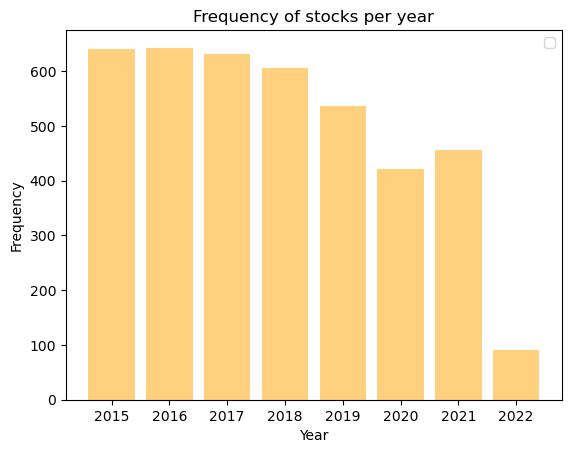

In [31]:
tmp = fundamentals[(fundamentals['fyear'].between(2015,2022))&(~fundamentals['pd_score'].isnull())].groupby(['fyear'])['LPERMNO'].count()

fyear_values = tmp.index
counts = tmp.values

plt.bar(fyear_values, counts, color='orange', alpha=0.5)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of stocks per year')
plt.xticks(fyear_values)  # Set x-axis labels
plt.legend()

In [27]:
fundamentals.groupby('Region')['LPERMNO'].count()

Region
Midwest       616
Northeast    2107
South        1716
West         2403
Name: LPERMNO, dtype: int64

In [28]:
fundamentals.groupby('Division')['LPERMNO'].count()

Division
East North Central     316
East South Central      77
Middle Atlantic       1252
Mountain               589
New England            855
Pacific               1814
South Atlantic         945
West North Central     300
West South Central     694
Name: LPERMNO, dtype: int64

In [29]:
fundamentals = fundamentals[(fundamentals['fyear']>2014)&(fundamentals['fyear']<2023)&(~fundamentals['pd_score'].isnull())]
fundamentals.groupby('fyear')['pd_score'].count()

fyear
2015    641
2016    643
2017    631
2018    606
2019    536
2020    421
2021    457
2022     90
Name: pd_score, dtype: int64

In [14]:
fundamentals['sic1'] = fundamentals['sic'].astype(str).str[:1]
fundamentals['gind2'] = fundamentals['gind'].astype(str).str[:2]
fundamentals['default'] = np.where(fundamentals['pd_score']>=0.07,1,0)

In [15]:
fundamentals.to_csv('credit_risk_master_table.csv')


# Correlations analysis

## Categoricals

In [11]:
categoricals = []
for i in fundamentals.columns:
    if fundamentals[i].dtype=='object':
        categoricals = categoricals + [i]
categoricals

['LINKDT',
 'datadate',
 'indfmt',
 'consol',
 'popsrc',
 'datafmt',
 'tic',
 'conm',
 'curcd',
 'costat',
 'fic',
 'ceoso',
 'cfoso',
 'city',
 'conml',
 'state',
 'ipodate',
 'Company Name',
 'State',
 'State Code',
 'Region',
 'Division']

In [ ]:
'city', 'state','sic'  | 'tic','conm','conml'

In [12]:
fundamentals[categoricals].head()

,LINKDT,datadate,indfmt,consol,popsrc,datafmt,tic,conm,curcd,costat,...,cfoso,city,conml,state,ipodate,Company Name,State,State Code,Region,Division
777,2007-08-27,2015-12-31,INDL,C,D,STD,SNCA,SENECA BIOPHARMA INC,USD,I,...,Y,Germantown,Seneca Biopharma Inc,MD,NaN,SENECA BIOPHARMA INC,Maryland,MD,South,South Atlantic
778,1993-12-01,2015-12-31,INDL,C,D,STD,PRKR,PARKERVISION INC,USD,A,...,Y,Jacksonville,ParkerVision Inc,FL,1993-11-30,PARKERVISION INC,Florida,FL,South,South Atlantic
782,2013-09-30,2015-12-31,INDL,C,D,STD,DOMH,DOMINARI HOLDINGS INC,USD,A,...,Y,New York,Dominari Holdings Inc,NY,NaN,DOMINARI HOLDINGS INC,New York,NY,Northeast,Middle Atlantic
783,2014-02-11,2015-12-31,INDL,C,D,STD,PHIO,PHIO PHARMACEUTICALS CORP,USD,A,...,Y,Marlborough,Phio Pharmaceuticals Corp,MA,NaN,PHIO PHARMACEUTICALS CORP,Massachusetts,MA,Northeast,New England
786,2012-02-16,2015-12-31,INDL,C,D,STD,NUWE,NUWELLIS INC,USD,A,...,Y,Eden Prairie,Nuwellis Inc,MN,NaN,NUWELLIS INC,Minnesota,MN,Midwest,West North Central


In [13]:
fundamentals['sic'].astype(str).str[:1].unique()

array(['2', '3', '7', '4', '1', '8', '5', '9'], dtype=object)

In [14]:
fundamentals['gind'].astype(str).str[:2].unique()

array(['35', '45', '20', '30', '55', '10', '15', '50', '25', '40', '60'],
      dtype=object)

In [15]:
for j in categoricals:
    print(j,len(fundamentals[j].unique()))

LINKDT 1008
datadate 95
indfmt 1
consol 1
popsrc 1
datafmt 1
tic 1196
conm 1196
curcd 1
costat 2
fic 1
ceoso 3
cfoso 3
city 485
conml 1196
state 53
ipodate 630
Company Name 1196
State 49
State Code 49
Region 5
Division 10


## Continuous

In [16]:
correlations = fundamentals.corr()[['pd_score']]
correlations

,pd_score
GVKEY,0.105004
LPERMNO,-0.034349
fyear,-0.027611
acchg,NaN
acco,NaN
...,...
gind,-0.061350
sic,0.035857
market_cap,-0.105332
Year,-0.027611


In [17]:
correlations = correlations.sort_values('pd_score')
correlations['n'] = fundamentals[correlations.index].count()
correlations

,pd_score,n
spce,-0.989812,3
spceeps,-0.896989,3
spced,-0.896989,3
uspi,-0.526601,32
ugi,-0.488478,32
...,...,...
xuwnli,NaN,0
xuwoi,NaN,0
xuwrei,NaN,0
xuwti,NaN,0


In [18]:
continuos = []
for i in fundamentals.columns:
    if i not in categoricals and i!='pd_score':
        continuos = continuos+[i]
len(continuos)

898

In [15]:
correlations.to_csv('correlations.csv')

In [19]:
len(fundamentals)

4025

In [20]:
fundamentals['pd_score'].quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

0.0    0.000000
0.1    0.000039
0.2    0.000231
0.3    0.000702
0.4    0.001729
0.5    0.003528
0.6    0.007520
0.7    0.016248
0.8    0.032420
0.9    0.073607
1.0    0.505521
Name: pd_score, dtype: float64

In [21]:
fundamentals2 = fundamentals.sort_values('pd_score')
vars = []
for i in continuos:
    if i not in ['pd_score','GVKEY','LPERMNO','fyear','Year','sic']:
        fundamentals2[i] = np.where(fundamentals2[i].isnull(),0,fundamentals2[i])
        vars = vars +[i]
    

In [22]:
## Tree for bivariate
from sklearn.tree import DecisionTreeClassifier
fundamentals2['default'] = np.where(fundamentals2['pd_score']>=0.07,1,0)

X_train = fundamentals2[vars]
y_train = fundamentals2['default']

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [23]:
importances = pd.DataFrame()
importances['vars'] =clf.feature_names_in_
importances['importance'] = clf.feature_importances_
importances['perc_imp'] = importances['importance']/importances['importance'].sum()
importances.sort_values('perc_imp', ascending=False, inplace=True)
importances.head()

,vars,importance,perc_imp
92,ceqt,0.091699,0.091699
892,market_cap,0.091490,0.091490
886,prcc_f,0.053051,0.053051
850,xint,0.046571,0.046571
341,ib,0.026345,0.026345


In [24]:
importances.to_csv('importances_tree_bivariate.csv')

# Multivariate

In [2]:
fundamentals = pd.read_csv('credit_risk_master_table.csv',index_col=0).reset_index(drop=True)
print(len(fundamentals))
fundamentals.head()

4025


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,Year,Company Name,pd_score,State,State Code,Region,Division,sic1,gind2,default
0,176229,92252,2007-08-27,2015-12-31,2015,INDL,C,D,STD,SNCA,...,2016.0,SENECA BIOPHARMA INC,0.024809,Maryland,MD,South,South Atlantic,2,35,0
1,29332,80019,1993-12-01,2015-12-31,2015,INDL,C,D,STD,PRKR,...,2016.0,PARKERVISION INC,0.024382,Florida,FL,South,South Atlantic,3,45,0
2,18738,18148,2013-09-30,2015-12-31,2015,INDL,C,D,STD,DOMH,...,2016.0,DOMINARI HOLDINGS INC,0.080101,New York,NY,Northeast,Middle Atlantic,2,35,1
3,171187,14468,2014-02-11,2015-12-31,2015,INDL,C,D,STD,PHIO,...,2016.0,PHIO PHARMACEUTICALS CORP,0.006181,Massachusetts,MA,Northeast,New England,2,35,0
4,271987,13279,2012-02-16,2015-12-31,2015,INDL,C,D,STD,NUWE,...,2016.0,NUWELLIS INC,0.068560,Minnesota,MN,Midwest,West North Central,3,35,0


In [3]:
bivariate_vars = pd.read_csv('bivariate_vars.csv')
bivariate_vars.head()


,variables,data_correlations,data_tree,data_pca,data_professor,Description
0,dltis,1,0,0,0,Long-Term Debt Issuance
1,dm,1,0,0,0,Debt Mortgages & Other Secured
2,capxv,1,1,0,0,"Capital Expend Property, Plant and Equipment S..."
3,capx,1,0,0,0,Capital Expenditures
4,dd5,1,0,0,0,Debt Due in 5th Year


In [4]:
categoricals = ['sic1', 'gind2', 'Region']

for i in categoricals:
    cat = fundamentals[[i, 'pd_score']].groupby(i)['pd_score'].mean().reset_index().rename(columns={'pd_score': i+'_st'})
    fundamentals = fundamentals.merge(cat,on=i,how='left')
    
fundamentals.head() 



,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,State,State Code,Region,Division,sic1,gind2,default,sic1_st,gind2_st,Region_st
0,176229,92252,2007-08-27,2015-12-31,2015,INDL,C,D,STD,SNCA,...,Maryland,MD,South,South Atlantic,2,35,0,0.021497,0.024204,0.028697
1,29332,80019,1993-12-01,2015-12-31,2015,INDL,C,D,STD,PRKR,...,Florida,FL,South,South Atlantic,3,45,0,0.023287,0.019803,0.028697
2,18738,18148,2013-09-30,2015-12-31,2015,INDL,C,D,STD,DOMH,...,New York,NY,Northeast,Middle Atlantic,2,35,1,0.021497,0.024204,0.021497
3,171187,14468,2014-02-11,2015-12-31,2015,INDL,C,D,STD,PHIO,...,Massachusetts,MA,Northeast,New England,2,35,0,0.021497,0.024204,0.021497
4,271987,13279,2012-02-16,2015-12-31,2015,INDL,C,D,STD,NUWE,...,Minnesota,MN,Midwest,West North Central,3,35,0,0.023287,0.024204,0.020772


In [5]:
vars_finales = fundamentals[bivariate_vars['variables'].values.tolist() + ['sic1_st','gind2_st','Region_st','pd_score']]
vars_finales.head()


,dltis,dm,capxv,capx,dd5,dxd5,lcoxdr,dd1,np,dn,...,ppegt,invt,lt,sic1,gind2,Region,sic1_st,gind2_st,Region_st,pd_score
0,0.0,3.392,0.176,0.176,0.0,0.0,0.424,4.635,0.0,0.0,...,0.972,0.000,10.081,2,35,South,0.021497,0.024204,0.028697,0.024809
1,0.0,0.000,0.051,0.051,0.0,0.0,0.074,0.054,0.0,0.0,...,9.792,0.161,4.090,3,45,South,0.023287,0.019803,0.028697,0.024382
2,0.0,0.000,0.002,0.002,0.0,0.0,3.782,0.000,0.0,0.0,...,0.338,0.000,4.944,2,35,Northeast,0.021497,0.024204,0.021497,0.080101
3,0.0,0.000,0.057,0.057,0.0,0.0,0.000,0.000,0.0,0.0,...,0.941,0.000,2.269,2,35,Northeast,0.021497,0.024204,0.021497,0.006181
4,8.0,3.941,0.199,0.199,0.0,0.0,1.368,3.858,0.0,0.0,...,1.645,0.000,12.399,3,35,Midwest,0.023287,0.024204,0.020772,0.068560


In [51]:
multivariate = vars_finales.corr()
multivariate['n'] = fundamentals[multivariate.columns].count()
multivariate.to_csv('multivariate.csv')
multivariate.head()

,dltis,dm,capxv,capx,dd5,dxd5,lcoxdr,dd1,np,dn,...,ppegt,invt,lt,sic1,gind2,sic1_st,gind2_st,Region_st,pd_score,n
dltis,1.000000,0.457112,0.413791,0.413791,0.543333,0.552167,0.226860,0.115320,0.122545,0.244347,...,0.262664,0.077224,0.552663,-0.047934,-0.075721,0.027759,0.097282,0.047219,0.051484,3978
dm,0.457112,1.000000,0.460450,0.460450,0.312302,0.309846,0.217739,0.106041,-0.001505,0.535859,...,0.564927,0.014979,0.750962,-0.030295,-0.015240,0.059232,0.138470,0.080501,0.053973,3918
capxv,0.413791,0.460450,1.000000,1.000000,0.358429,0.357236,0.314951,0.026695,0.041346,0.419053,...,0.514790,0.034366,0.445841,-0.064128,-0.144362,0.148417,0.113914,0.085793,0.055523,4021
capx,0.413791,0.460450,1.000000,1.000000,0.358429,0.357236,0.314951,0.026695,0.041346,0.419053,...,0.514790,0.034366,0.445841,-0.064128,-0.144362,0.148417,0.113914,0.085793,0.055523,4021
dd5,0.543333,0.312302,0.358429,0.358429,1.000000,0.999895,0.219417,0.027466,-0.005793,0.312395,...,0.219335,0.023808,0.412244,-0.036464,-0.020078,0.016407,0.029824,0.054238,0.058726,3512


In [8]:
final_var = pd.read_csv('final_variables.csv')
final_var.head()

,wharton,Description
0,np,Notes Payable Short-Term Borrowings
1,ivstch,Short-Term Investments Change
2,dlc,Debt in Current Liabilities - Total
3,dt,Total Debt Including Current
4,auop,Auditor Opinion


In [14]:
finals_var = ['LPERMNO','fyear','sic','gind','Region','conml','conm']+final_var['wharton'].to_list()+['pd_score']
fundamentals[finals_var].to_csv('pre_final_master_table.csv')


# Models

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from imblearn import over_sampling

### Reading files

In [2]:
master = pd.read_csv('credit_risk_master_table.csv',index_col=0)
master.head()

,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,Year,Company Name,pd_score,State,State Code,Region,Division,sic1,gind2,default
777,176229,92252,2007-08-27,2015-12-31,2015,INDL,C,D,STD,SNCA,...,2016.0,SENECA BIOPHARMA INC,0.024809,Maryland,MD,South,South Atlantic,2,35,0
778,29332,80019,1993-12-01,2015-12-31,2015,INDL,C,D,STD,PRKR,...,2016.0,PARKERVISION INC,0.024382,Florida,FL,South,South Atlantic,3,45,0
782,18738,18148,2013-09-30,2015-12-31,2015,INDL,C,D,STD,DOMH,...,2016.0,DOMINARI HOLDINGS INC,0.080101,New York,NY,Northeast,Middle Atlantic,2,35,1
783,171187,14468,2014-02-11,2015-12-31,2015,INDL,C,D,STD,PHIO,...,2016.0,PHIO PHARMACEUTICALS CORP,0.006181,Massachusetts,MA,Northeast,New England,2,35,0
786,271987,13279,2012-02-16,2015-12-31,2015,INDL,C,D,STD,NUWE,...,2016.0,NUWELLIS INC,0.068560,Minnesota,MN,Midwest,West North Central,3,35,0


In [3]:
final_vars = pd.read_csv('final_final_variables.csv')
final_vars.head()

,wharton,Description,var,levels,Decision,corr pd_score,Fill Rate,corr,tree,pca,prof
0,np,Notes Payable Short-Term Borrowings,np,NaN,No,7.40%,100%,1.0,1.0,0.0,0.0
1,ivstch,Short-Term Investments Change,ivstch,Never,No,8.55%,81%,1.0,0.0,0.0,0.0
2,dlc,Debt in Current Liabilities - Total,dlc,Never,No,9.13%,100%,1.0,1.0,0.0,0.0
3,dt,Total Debt Including Current,dt,NaN,maybe,10.21%,99%,1.0,1.0,0.0,0.0
4,auop,Auditor Opinion,auop,Never,No,23.09%,100%,1.0,1.0,0.0,0.0


In [4]:
keys = ['LPERMNO','fyear','conml','conm','sic']
vars_yes = list(final_vars[final_vars['Decision']=='si']['var'].values)
vars_yes.remove('sic1_st')
vars_maybe = list(final_vars[final_vars['Decision']=='maybe']['var'].values)
vars_maybe.remove('Region_st')
cat_yes = ['sic1']
cat_maybe = ['Region']
cat_yes_num = ['sic1_st']
cat_maybe_num = ['Region_st']
target = ['pd_score']

In [5]:
total_vars = keys+vars_yes+vars_maybe+cat_yes+cat_maybe+target
vars_modeling_yes = vars_yes+cat_yes
vars_modeling = vars_yes+vars_maybe+cat_yes+cat_maybe

In [6]:
master_final = master[total_vars]
master_final['default'] = np.where(master_final['pd_score']>0.07,1,0)
master_final.head()

,LPERMNO,fyear,conml,conm,sic,wcap,ebit,dltt,recch,emp,...,che,ni,dt,act,fatl,invt,sic1,Region,pd_score,default
777,92252,2015,Seneca Biopharma Inc,SENECA BIOPHARMA INC,2836,7.006,-19.157,3.392,0.188,0.033,...,12.234,-20.904,8.027,13.521,0.040,0.000,2,South,0.024809,0
778,80019,2015,ParkerVision Inc,PARKERVISION INC,3663,-1.685,-16.753,0.000,-0.004,0.023,...,1.965,-17.075,0.054,2.353,0.926,0.161,3,South,0.024382,0
782,18148,2015,Dominari Holdings Inc,DOMINARI HOLDINGS INC,2836,-0.592,-11.410,0.000,0.000,0.004,...,3.534,-51.465,0.000,3.864,0.229,0.000,2,Northeast,0.080101,1
783,14468,2015,Phio Pharmaceuticals Corp,PHIO PHARMACEUTICALS CORP,2836,8.709,-10.237,0.000,0.000,0.016,...,10.667,-10.223,0.000,10.978,NaN,0.000,2,Northeast,0.006181,0
786,13279,2015,Nuwellis Inc,NUWELLIS INC,3845,15.594,-25.958,3.941,0.059,0.038,...,23.113,-26.583,7.799,23.652,0.145,0.000,3,Midwest,0.068560,0


In [7]:
master_final.groupby('fyear')['pd_score'].mean()

fyear
2015    0.031006
2016    0.023269
2017    0.018612
2018    0.023163
2019    0.031379
2020    0.019363
2021    0.023771
2022    0.017577
Name: pd_score, dtype: float64

### Train-Test split

In [8]:
master_final.groupby('fyear')['LPERMNO'].count()

fyear
2015    641
2016    643
2017    631
2018    606
2019    536
2020    421
2021    457
2022     90
Name: LPERMNO, dtype: int64

In [9]:
train_set = master_final[master_final['fyear']<2020]
val_set = master_final[master_final['fyear']==2020]
test_set = master_final[master_final['fyear']>2020]
print(len(train_set)/(len(train_set)+len(val_set)+len(test_set)),len(val_set)/(len(train_set)+len(val_set)+len(test_set)),len(test_set)/(len(train_set)+len(val_set)+len(test_set)))


0.7595031055900621 0.10459627329192546 0.13590062111801243


### Variable descriptives and missing analysis

In [68]:
descriptive = train_set.describe().T
descriptive['fill_rate'] = descriptive['count']/len(train_set)
descriptive

,count,mean,std,min,25%,50%,75%,max,fill_rate
LPERMNO,3057.0,48799.054629,34534.439556,10001.000000,14836.000000,34666.000000,85540.000000,93434.000000,1.000000
fyear,3057.0,2016.919202,1.393826,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,1.000000
sic,3057.0,4083.596336,1911.226068,100.000000,2836.000000,3651.000000,4833.000000,9997.000000,1.000000
wcap,3034.0,46.319880,97.877459,-472.358000,4.270000,17.102500,50.885250,1620.489000,0.992476
ebit,3057.0,-23.152177,61.428532,-2137.012000,-26.617000,-8.111000,-0.111000,76.455000,1.000000
dltt,3039.0,21.778736,74.854876,0.000000,0.000000,1.028000,11.875500,2479.349000,0.994112
recch,2874.0,-0.520404,6.535011,-166.470000,-1.349000,-0.101000,0.481000,66.423000,0.940137
emp,3026.0,0.225518,0.541449,0.000000,0.053000,0.114000,0.248000,17.100000,0.989859
teq,3057.0,91.228693,532.800756,-841.334000,10.137000,29.266000,76.936000,10667.946000,1.000000
dlc,3057.0,3.568793,16.690736,0.000000,0.000000,0.209000,2.439000,483.326000,1.000000


In [79]:
for i in vars_yes+vars_maybe:
    train_set[i+'_st'] = np.where(train_set[i]<train_set[i].quantile(0.25),'1.'+str(train_set[i].quantile(0.25)),
                          np.where(train_set[i].between(train_set[i].quantile(0.25),train_set[i].quantile(0.5)),'2.'+str(train_set[i].quantile(0.5)),
                          np.where(train_set[i]>train_set[i].quantile(0.5),'3.'+str(train_set[i].quantile(0.75)),
                          np.where(train_set[i].isnull(),'4.missing','0.'))))
    print(train_set.groupby(i+'_st')['pd_score'].agg(['count','mean']))
    print(train_set[i].mean())
    

            count      mean
wcap_st                    
1.4.27        759  0.053441
2.17.1025     758  0.023067
3.50.88525   1517  0.012267
4.missing      23  0.033985
46.319880026367834
           count      mean
ebit_st                   
1.-26.617    764  0.025304
2.-8.111     765  0.037794
3.-0.111    1528  0.019105
-23.152176970886494
                      count      mean
dltt_st                              
2.1.028                1520  0.020313
3.11.875499999999999   1519  0.030273
4.missing                18  0.031988
21.77873642645607
                       count      mean
recch_st                              
1.-1.3490000000000002    719  0.017172
2.-0.101                 720  0.023237
3.0.481                 1435  0.031161
4.missing                183  0.019913
-0.5204036186499652
           count      mean
emp_st                    
1.0.053      747  0.037369
2.0.114      767  0.027164
3.0.248     1512  0.018072
4.missing     31  0.043984
0.2255181758096497
          count

In [81]:
train_set['sic1'] = np.where(train_set['sic1'].isnull(),'null',train_set['sic1'])
train_set.groupby('sic1')['pd_score'].agg(['count','mean'])

,count,mean
sic1,,
1,161,0.040389
2,1127,0.023121
3,938,0.024305
4,152,0.022036
5,91,0.028320
7,476,0.025841
8,106,0.030742
9,6,0.098950


In [82]:
train_set['Region'] = np.where(train_set['Region'].isnull(),'null',train_set['Region'])
train_set.groupby('Region')['pd_score'].agg(['count','mean'])
	

,count,mean
Region,,
Midwest,285,0.019269
Northeast,912,0.022216
South,751,0.029689
West,1019,0.024741
null,90,0.046405


### Filling missings

In [10]:
def fillna_df(df):
    df['wcap'] = df['wcap'].fillna(0)
    mean_dltt = train_set['dltt'].mean()
    df['dltt'] = df['dltt'].fillna(mean_dltt)
    mean_recch = train_set['recch'].mean()
    df['recch'] = df['recch'].fillna(mean_recch)
    df['emp'] = df['emp'].fillna(0)
    df['ppegt'] = df['ppegt'].fillna(0)
    mean_dt = train_set['dt'].mean()
    df['dt'] = df['dt'].fillna(mean_dt)
    df['act'] = df['act'].fillna(0)
    mean_fatl = train_set['fatl'].median()
    df['fatl'] = df['fatl'].fillna(mean_fatl)     
    mean_invt = train_set['invt'].mean()
    df['invt'] = df['invt'].fillna(mean_invt)    
    df['sic1'] = np.where(df['sic1'].isnull(),'null',df['sic1']) 
    df['Region'] = np.where(df['Region'].isnull(),'null',df['Region'])
    
    return df


In [11]:
train_set = fillna_df(train_set)
test_set = fillna_df(test_set)
val_set = fillna_df(val_set)

### Categoric transformation

In [12]:
for i in cat_yes+cat_maybe:
    cat = train_set[[i, 'pd_score']].groupby(i)['pd_score'].mean().reset_index().rename(columns={'pd_score': i+'_st'})
    train_set = train_set.merge(cat,on=i,how='left')
    test_set = test_set.merge(cat,on=i,how='left')
    val_set = val_set.merge(cat,on=i,how='left')
    
train_set.head() 

,LPERMNO,fyear,conml,conm,sic,wcap,ebit,dltt,recch,emp,...,dt,act,fatl,invt,sic1,Region,pd_score,default,sic1_st,Region_st
0,92252,2015,Seneca Biopharma Inc,SENECA BIOPHARMA INC,2836,7.006,-19.157,3.392,0.188,0.033,...,8.027,13.521,0.040,0.000,2,South,0.024809,0,0.023121,0.029689
1,80019,2015,ParkerVision Inc,PARKERVISION INC,3663,-1.685,-16.753,0.000,-0.004,0.023,...,0.054,2.353,0.926,0.161,3,South,0.024382,0,0.024305,0.029689
2,18148,2015,Dominari Holdings Inc,DOMINARI HOLDINGS INC,2836,-0.592,-11.410,0.000,0.000,0.004,...,0.000,3.864,0.229,0.000,2,Northeast,0.080101,1,0.023121,0.022216
3,14468,2015,Phio Pharmaceuticals Corp,PHIO PHARMACEUTICALS CORP,2836,8.709,-10.237,0.000,0.000,0.016,...,0.000,10.978,0.863,0.000,2,Northeast,0.006181,0,0.023121,0.022216
4,13279,2015,Nuwellis Inc,NUWELLIS INC,3845,15.594,-25.958,3.941,0.059,0.038,...,7.799,23.652,0.145,0.000,3,Midwest,0.068560,0,0.024305,0.019269


### SMOTE X and Y definition

In [13]:
vars_modeling_yes = vars_yes+cat_yes_num
vars_modeling = vars_yes+vars_maybe+cat_yes_num+cat_maybe_num

In [14]:
X_train = train_set[vars_modeling]
X_val = val_set[vars_modeling]
X_test = test_set[vars_modeling]
y_train = train_set['default']
y_val = val_set['default']
y_test = test_set['default']

In [27]:
print(len(y_train),len(y_val),len(y_test))
print(sum(y_train),sum(y_val),sum(y_test))

3057 421 547
353 23 56


In [63]:
smote = over_sampling.SMOTE(sampling_strategy='minority',random_state=123,k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [16]:
#winner
smote = over_sampling.SMOTEN(sampling_strategy='minority',random_state=123,k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [82]:
smote = over_sampling.ADASYN(sampling_strategy='minority',random_state=123,n_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [90]:
smote = over_sampling.SVMSMOTE(sampling_strategy='minority',random_state=123,k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [49]:
over = over_sampling.RandomOverSampler(sampling_strategy=0.5,random_state=123)
X_train_oversample, y_train_oversample = over.fit_resample(X_train, y_train)


In [17]:
#winner
over = over_sampling.RandomOverSampler(sampling_strategy='minority',random_state=123)
X_train_oversample, y_train_oversample = over.fit_resample(X_train, y_train)


## Models

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix


In [20]:
def show_basic_matrics(y_test, y_pred, y_prob):
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    
    # Calculate confusion matrix
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred),index=['Actual 0', 'Actual 1'],columns=['Predicted 0', 'Predicted 1'])
    print(conf_matrix)
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    
    # Choose a threshold
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    print("optimal_threshold: ",optimal_threshold)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f, GINI=%0.2f)' % (roc_auc, gini))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


### Tree

In [ ]:
x_trains = [X_train, X_train_oversample, X_train_resampled]
y_trains = [y_train, y_train_oversample, y_train_resampled]
max_depth = [6,8,10]
min_samples_leaf = [50,30,20]

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       398
           1       0.17      0.35      0.23        23

    accuracy                           0.87       421
   macro avg       0.56      0.62      0.58       421
weighted avg       0.92      0.87      0.89       421

          Predicted 0  Predicted 1
Actual 0          358           40
Actual 1           15            8
optimal_threshold:  1.0


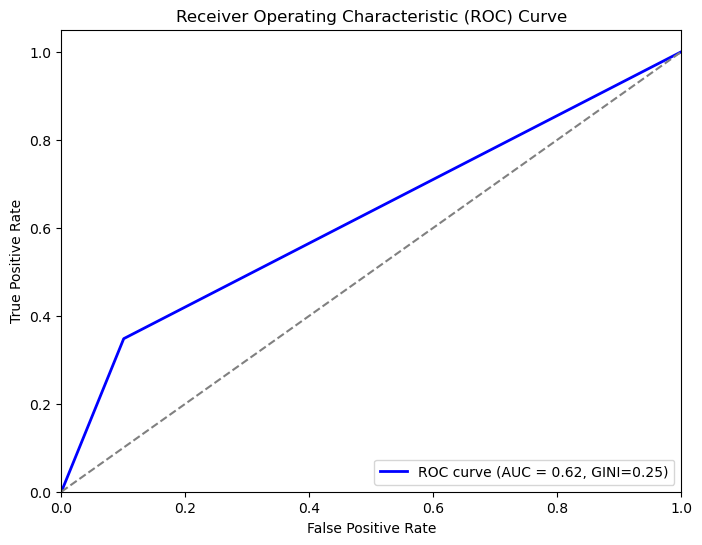

In [23]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=123)

# Train the classifier on the training data
clf.fit(X_train_oversample, y_train_oversample)

# Make predictions on the testing data
#y_pred = clf.predict(X_test)
#y_prob = clf.predict_proba(X_test)[:, 1]

# Make predictions on the testing data
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:, 1]

show_basic_matrics(y_val, y_pred, y_prob)


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       398
           1       0.17      0.43      0.24        23

    accuracy                           0.85       421
   macro avg       0.57      0.66      0.58       421
weighted avg       0.92      0.85      0.88       421

          Predicted 0  Predicted 1
Actual 0          349           49
Actual 1           13           10
optimal_threshold:  1.0


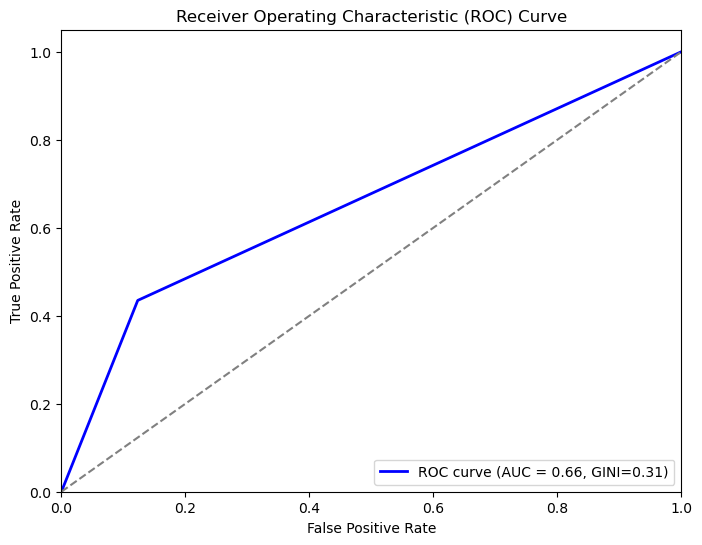

In [24]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=123)

# Train the classifier on the training data
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
#y_pred = clf.predict(X_test)
#y_prob = clf.predict_proba(X_test)[:, 1]

# Make predictions on the testing data
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:, 1]

show_basic_matrics(y_val, y_pred, y_prob)


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       398
           1       0.13      0.35      0.19        23

    accuracy                           0.84       421
   macro avg       0.55      0.61      0.55       421
weighted avg       0.91      0.84      0.87       421

          Predicted 0  Predicted 1
Actual 0          346           52
Actual 1           15            8
optimal_threshold:  1.0


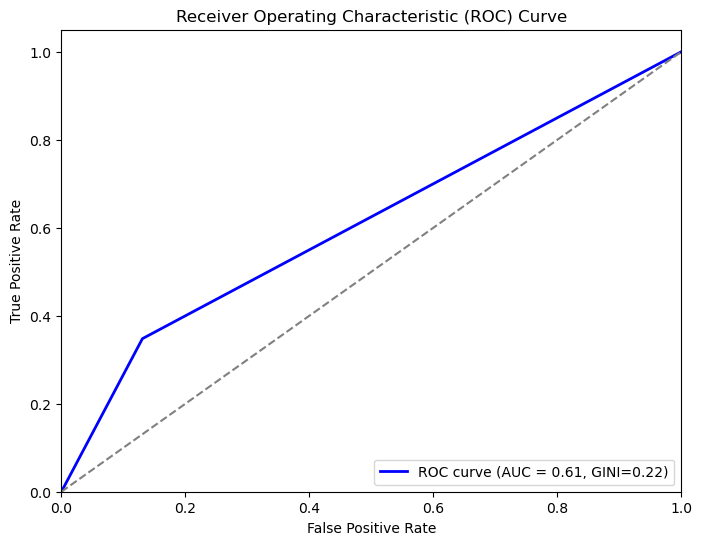

In [25]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=123)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
#y_pred = clf.predict(X_test)
#y_prob = clf.predict_proba(X_test)[:, 1]

# Make predictions on the testing data
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:, 1]

show_basic_matrics(y_val, y_pred, y_prob)


### Regression

In [ ]:
x_trains = [X_train, X_train_oversample, X_train_resampled]
y_trains = [y_train, y_train_oversample, y_train_resampled]
alpha = [0,0.25,0.5,0.75]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2941262024255715
            Iterations: 79
            Function evaluations: 101
            Gradient evaluations: 79
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 3057
Model:                          Logit   Df Residuals:                     3040
Method:                           MLE   Df Model:                           16
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.1780
Time:                        14:33:43   Log-Likelihood:                -899.14
converged:                       True   LL-Null:                       -1093.8
Covariance Type:            nonrobust   LLR p-value:                 6.224e-73
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

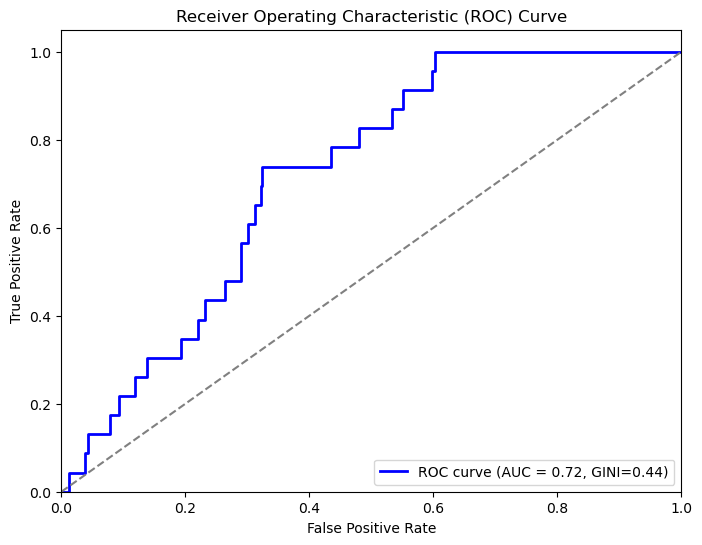

In [28]:
# Add constant to the independent variables (statsmodels requires this)
X_train_c = sm.add_constant(X_train)
X_test_c = sm.add_constant(X_test)
X_val_c = sm.add_constant(X_val)

# Fit logistic regression model on training data
model = sm.Logit(y_train, X_train_c).fit_regularized(method='l1',alpha=0)

# Print summary of the model
print(model.summary())

# Make predictions on the testing data
y_prob = model.predict(X_val_c)
y_pred = np.round(y_prob)  # Convert probabilities to binary predictions (0 or 1)

show_basic_matrics(y_val, y_pred, y_prob)


Optimization terminated successfully.
         Current function value: 0.531500
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 5408
Model:                          Logit   Df Residuals:                     5391
Method:                           MLE   Df Model:                           16
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.2332
Time:                        14:08:12   Log-Likelihood:                -2874.4
converged:                       True   LL-Null:                       -3748.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3499      0.236     -5.711      0.000      -1.813      -0.887
wcap           0.0067      0.

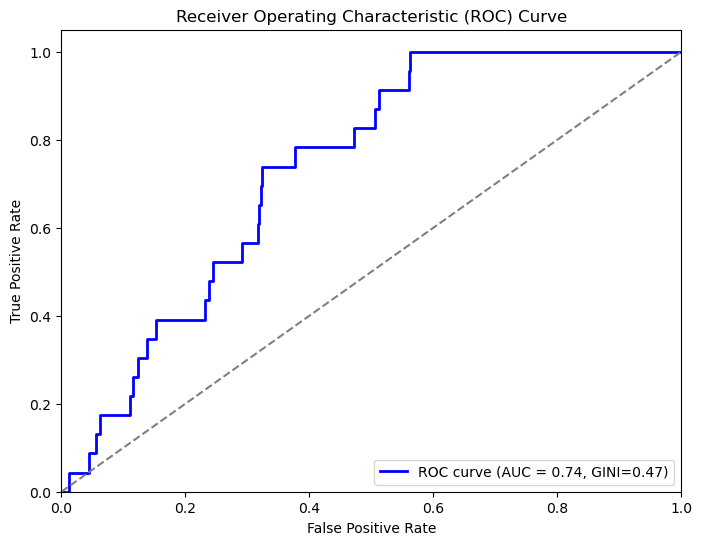

In [22]:
# Add constant to the independent variables (statsmodels requires this)
X_train_oversample_c = sm.add_constant(X_train_oversample)
X_test_c = sm.add_constant(X_test)
X_val_c = sm.add_constant(X_val)

# Fit logistic regression model on training data
model = sm.Logit(y_train_oversample, X_train_oversample_c).fit()

# Print summary of the model
print(model.summary())

# Make predictions on the testing data
y_prob = model.predict(X_val_c)
y_pred = np.round(y_prob)  # Convert probabilities to binary predictions (0 or 1)

show_basic_matrics(y_val, y_pred, y_prob)


Optimization terminated successfully.
         Current function value: 0.266501
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 5408
Model:                          Logit   Df Residuals:                     5391
Method:                           MLE   Df Model:                           16
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.6155
Time:                        14:08:57   Log-Likelihood:                -1441.2
converged:                       True   LL-Null:                       -3748.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1256      0.351     -0.358      0.720      -0.813       0.562
wcap          -0.0413      0

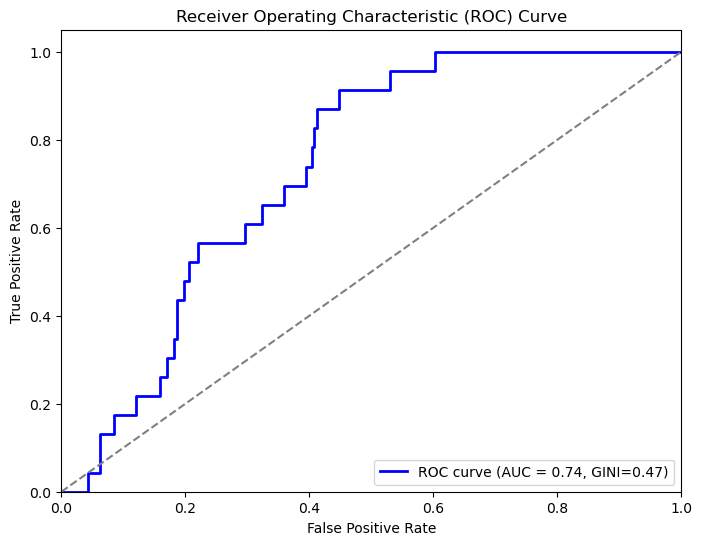

In [23]:
# Add constant to the independent variables (statsmodels requires this)
X_train_resampled_c = sm.add_constant(X_train_resampled)
X_test_c = sm.add_constant(X_test)
X_val_c = sm.add_constant(X_val)

# Fit logistic regression model on training data
model = sm.Logit(y_train_resampled, X_train_resampled_c).fit()

# Print summary of the model
print(model.summary())

# Make predictions on the testing data
y_prob = model.predict(X_val_c)
y_pred = np.round(y_prob)  # Convert probabilities to binary predictions (0 or 1)

show_basic_matrics(y_val, y_pred, y_prob)



### Random Forest

In [ ]:
x_trains = [X_train, X_train_oversample, X_train_resampled]
y_trains = [y_train, y_train_oversample, y_train_resampled]
n_estimators = [10,50,100]
max_depth = [6,8,10,None]
min_samples_leaf = [30,20,10]

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       398
           1       0.27      0.13      0.18        23

    accuracy                           0.93       421
   macro avg       0.61      0.56      0.57       421
weighted avg       0.91      0.93      0.92       421

          Predicted 0  Predicted 1
Actual 0          390            8
Actual 1           20            3
optimal_threshold:  0.22353206415413557


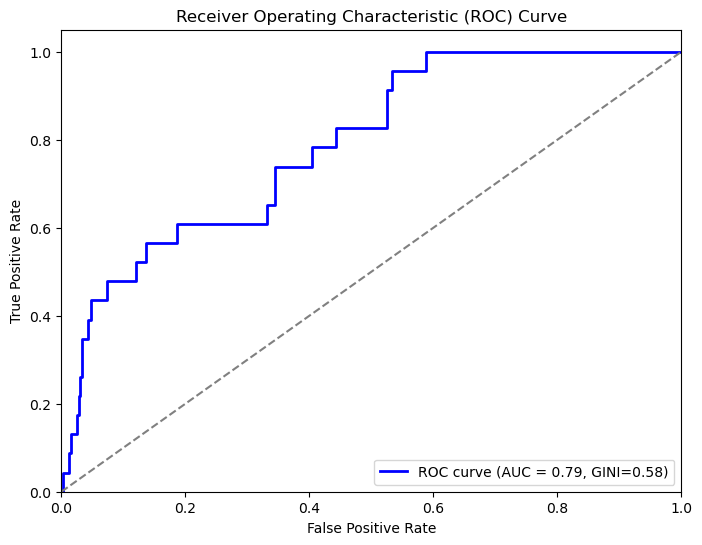

In [24]:
clf = RandomForestClassifier(max_depth=6, random_state=123)
# Train the classifier on the training data
clf.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:,1]

show_basic_matrics(y_val, y_pred, y_prob)


              precision    recall  f1-score   support

           0       0.97      0.72      0.83       398
           1       0.12      0.65      0.20        23

    accuracy                           0.71       421
   macro avg       0.55      0.69      0.51       421
weighted avg       0.93      0.71      0.79       421

          Predicted 0  Predicted 1
Actual 0          286          112
Actual 1            8           15
optimal_threshold:  0.3793481570679323


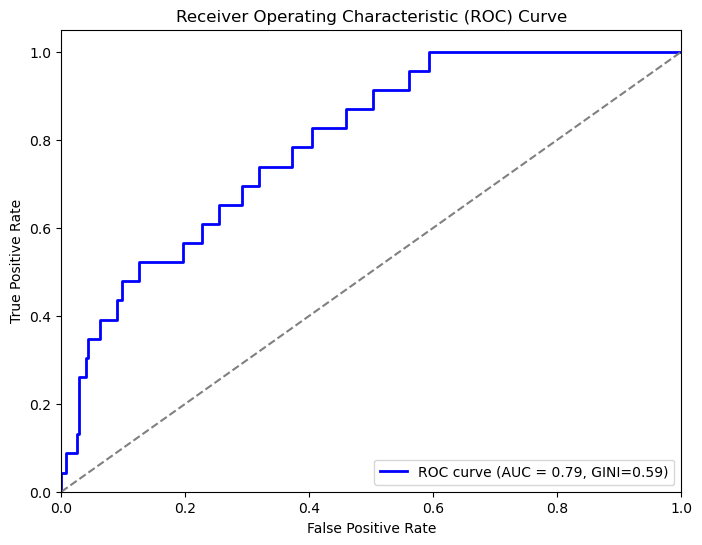

In [25]:
clf = RandomForestClassifier(max_depth=6, random_state=123)
# Train the classifier on the training data
clf.fit(X_train_oversample, y_train_oversample)
# Make predictions on the testing data
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:,1]

show_basic_matrics(y_val, y_pred, y_prob)


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       398
           1       0.19      0.22      0.20        23

    accuracy                           0.91       421
   macro avg       0.57      0.58      0.58       421
weighted avg       0.91      0.91      0.91       421

          Predicted 0  Predicted 1
Actual 0          377           21
Actual 1           18            5
optimal_threshold:  0.2384935019261103


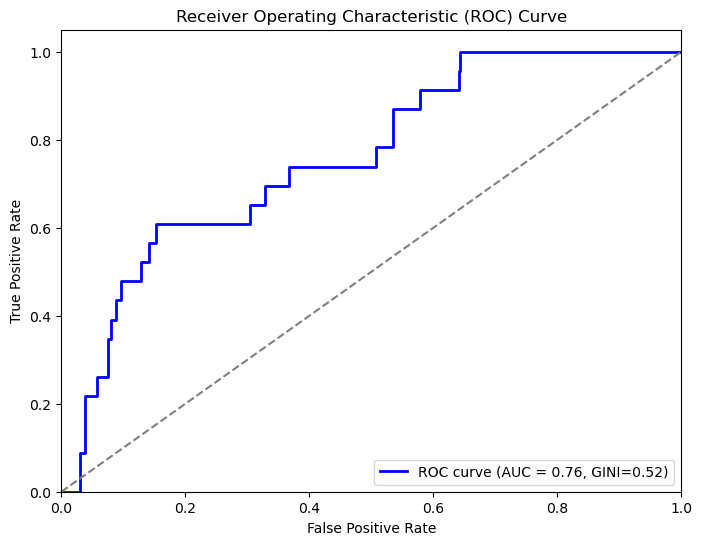

In [26]:
clf = RandomForestClassifier(max_depth=6, random_state=123)
# Train the classifier on the training data
clf.fit(X_train_resampled, y_train_resampled)
# Make predictions on the testing data
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:,1]

show_basic_matrics(y_val, y_pred, y_prob)
